In [15]:
import re
import os
from IPython.display import Image
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import math
import matplotlib.ticker as plticker
import json

class CustomRuntimeError(Exception):
    """Something failed in runtime"""
    def __init__(self,filename,message):
        self.filename = filename
        self.message = message

nvprof = "/usr/local/cuda-10.2/bin/nvprof"

def convolve(isize,fsize,static = 0):
#     @izise is the size of generated image for benchmarking, @fsize is filter size(diameter), @static is wether to use statically known filter-size funtions  
    commands = [
        f"{nvprof} --normalized-time-unit ms ./filter_spec.out --isize={isize} --fsize={fsize} --test=0 2> filter_spec.txt",
        f"{nvprof} --normalized-time-unit ms ./filter.out --isize={isize} --fsize={fsize} --static={static} --test=0 2> filter.txt",
        
    ]
    for command in commands:
        if(os.system(command) == 0):
            continue
        raise CustomRuntimeError(command,"")

files = [
    "filter_spec.txt",
    "filter.txt",
]

def time():
    rePatt = re.compile('lambda_\w*|ConvolutionFilter\w*')
    flt = re.compile('[\d]+\.?[\d]*') 
    result = []
    for f in files:
        with open(f) as fr:
            val = 0
            for line in fr:
                if(rePatt.findall(line) != []):
                    val = val + (float(flt.findall(line)[1]))
            result.append(val)
    return result

# for compile-time known kernel sizes
filters1 = [15,31,63,127,255]
# for runtime known
filters2 = [i for i in range(3,256,2)]


def test(iterations,static,filters,outputfile):
    res = []
    for f in filters:
        res_ = []
        for i in range(iterations):
#             16384x16384 random image
            convolve(16384,f,static)
            res_.append(time())
        res.append(res_)
    with open(outputfile,'w') as cts:
            cts.write(json.dumps(res))
    return res


# run benchmarks
test(2,1,filters1,"filter_hand")
test(2,0,filters2,"filter_default")

# spec_vs_handtuned = [[[42.86486, 42.85684], [42.85841, 42.1094], [42.85996, 42.85328], [42.85872, 42.87062], [42.85438, 41.05494]], [[77.33528000000001, 77.31421999999999], [77.346, 77.33775], [77.34281, 74.08377], [77.33932, 71.87102], [77.34198, 69.9423]], [[145.19525, 121.1944], [146.29362, 146.25556999999998], [146.31086, 139.15553], [137.95949000000002, 123.98246], [139.75044, 129.9904]], [[360.98213, 303.68192999999997], [344.66498, 309.49604], [353.59361, 309.64422], [334.64797, 311.07076], [342.20041, 302.82372]], [[494.7473, 480.33979999999997], [506.3179, 485.116], [516.578, 480.30719999999997], [540.1828, 483.805], [499.4329, 487.1097]]]
# spec_vs_default = [[[20.569074999999998, 24.82818], [20.575961, 25.72558], [20.571644, 25.56498], [20.424897, 24.711289999999998], [20.561441, 25.72185]], [[22.410161, 28.24407], [23.219561, 28.26269], [23.216625, 28.25584], [23.211598000000002, 28.22222], [21.935262, 26.9438]], [[26.199254000000003, 29.193440000000002], [26.203927, 28.88001], [26.212474, 28.40376], [23.917746, 28.994190000000003], [24.180076, 28.527430000000003]], [[28.280479999999997, 32.85204], [26.556279000000004, 32.83118], [30.269660000000002, 32.86641], [30.24711, 32.83499], [30.274910000000002, 32.859790000000004]], [[34.38588, 34.17441], [34.37462, 33.21281], [34.378460000000004, 36.49503], [34.38144, 36.474959999999996], [30.72326, 36.48261]], [[36.75731, 40.380210000000005], [38.59632, 40.38712], [37.64627, 36.67989], [38.58999, 38.50307], [35.90495, 35.86274]], [[37.26888, 39.4375], [40.79384, 44.457719999999995], [42.86943, 40.360240000000005], [37.22884, 39.44009], [42.86002, 44.46364]], [[47.195049999999995, 42.96595], [47.18834, 47.572540000000004], [47.19359, 49.42084], [47.19333, 49.43185], [41.86359, 43.915639999999996]], [[51.51262, 52.61755], [46.70691, 53.348609999999994], [51.50988, 49.4881], [50.22528, 53.35743000000001], [51.5135, 46.76524]], [[49.47753, 55.07101], [50.643840000000004, 54.6745], [49.49025, 49.94357], [55.82639, 57.51786], [49.48259, 53.469390000000004]], [[60.14145, 53.60743], [52.122960000000006, 54.10378], [53.317319999999995, 57.261070000000004], [55.84434, 54.68889], [60.12616, 61.61713]], [[64.43011, 65.92513], [57.12894, 57.26581], [57.12945, 59.90316], [64.42782, 62.7592], [59.84567, 65.89556]], [[62.37765, 69.9777], [68.73415, 69.95648], [60.95572, 62.10916], [62.37318, 69.97914], [68.72573, 69.97056]], [[73.02767, 67.40722], [73.02919, 64.28068999999999], [73.03239, 74.22362], [71.21289, 74.25968], [73.02618, 66.4353]], [[75.40401, 69.11655999999999], [77.33342999999999, 78.10201], [77.33315, 78.4423], [77.34227, 78.45626], [77.33491000000001, 68.08962]], [[81.65467000000001, 83.45879000000001], [79.61601, 83.47958], [81.67366, 77.48903], [81.65206, 83.46582000000001], [81.66617, 75.80987999999999]], [[85.95533, 77.98759], [76.22579999999999, 78.33501], [85.9613, 74.48848], [83.81681, 76.33189], [85.94924, 75.18761]], [[90.24893, 76.69656], [90.25999, 91.58943000000001], [90.25285, 91.59269], [90.25471, 79.48015000000001], [85.87033, 80.49503]], [[94.60736, 95.80781999999999], [94.60315, 92.27819], [94.55086, 82.99311], [83.93165, 95.83895000000001], [89.95781, 86.9646]], [[98.43145, 85.22475], [98.87299999999999, 88.75109], [98.86872, 100.06174], [98.85743000000001, 88.08219], [87.67697000000001, 88.75586]], [[102.79095999999998, 92.42219], [98.16367, 89.17729], [103.25137000000001, 104.21188000000001], [95.82042, 92.42123000000001], [91.48577, 89.48725999999999]], [[107.48616000000001, 95.71754999999999], [99.84036, 96.25059999999999], [107.48052, 96.27716], [95.30875, 91.79124999999999], [107.53920000000001, 90.11859]], [[110.86741, 93.44919], [111.87765999999999, 93.26756], [111.76839000000001, 112.77194], [111.87594000000001, 93.08215], [105.43038999999999, 99.99418]], [[116.12083000000001, 117.48032], [116.12889000000001, 117.47616], [116.07042999999999, 117.48492], [116.11472, 99.87666], [116.09987000000001, 109.12323]], [[120.43013, 107.73214000000002], [114.57786999999999, 107.73348], [106.8315, 102.80672], [119.76966000000002, 115.60014000000001], [106.82785999999999, 107.39791]], [[124.74768, 107.45682000000001], [118.66199, 122.15173999999999], [113.18309, 116.99267], [115.85415, 122.0495], [124.73414, 106.84764000000001]], [[129.08907, 115.34802], [114.49768, 109.54708], [129.10102, 117.41923], [129.09128, 118.03078], [119.92296999999999, 105.10243]], [[133.3915, 134.41809], [127.38722999999999, 119.17250000000001], [123.89916, 109.14605], [133.42136, 119.17634000000001], [118.30993, 118.0711]], [[137.71393, 120.28976], [137.72657, 128.74801], [137.70868000000002, 122.90527], [137.69876, 125.81011], [131.29667, 135.16402]], [[141.99475999999999, 132.8513], [131.88094, 126.83233999999999], [131.8949, 133.50306], [142.00679, 115.49547000000001], [135.10252, 119.65522]], [[146.33462, 133.57388], [132.72924, 120.77325], [132.76149, 129.26233000000002], [137.03234, 117.09049999999999], [146.31594, 119.29911000000001]], [[211.18322999999998, 197.00339000000002], [240.65167, 183.44261], [220.30045, 209.46506], [209.53852999999998, 182.52181000000002], [212.25202, 199.38036]], [[209.30693, 210.3442], [220.09523000000002, 202.71269999999998], [240.27984, 191.94835], [223.31068, 212.32121], [226.54323, 196.31528]], [[247.62947000000003, 218.14971], [226.71881000000002, 223.68468], [221.23085, 227.87835], [256.92004000000003, 238.05827], [215.7446, 223.95842]], [[216.33965999999998, 209.93182], [217.26334000000003, 210.54706000000002], [215.56719, 204.26634], [246.33936, 214.98806000000002], [217.27900999999997, 203.07798]], [[225.69934, 234.23476000000002], [277.15758999999997, 204.04632], [255.94332000000003, 216.13512000000003], [276.48885, 203.35392000000002], [263.26401, 210.55365999999998]], [[224.73561999999998, 209.20650999999998], [224.79723, 209.12899], [270.36984, 212.86287000000002], [240.6399, 236.57999], [229.63331, 221.37041000000002]], [[229.74161, 240.95247], [235.85192999999998, 234.42790000000002], [227.8256, 227.78497000000002], [228.70702999999997, 210.22589], [227.46395, 211.11236]], [[240.34617, 234.69216999999998], [244.02614, 238.66305], [279.32508, 239.92551], [279.47081000000003, 227.46214], [267.4679, 220.19864]], [[246.94515, 242.43005], [236.51498, 223.14498], [243.17077999999998, 217.51372], [237.07439, 239.48062], [290.97816, 224.74871]], [[237.87139000000002, 229.37136], [291.93768, 244.60835], [293.01655, 249.32333], [239.74782, 228.43579999999997], [267.51242, 222.05039999999997]], [[257.01604, 231.05531000000002], [262.80845, 232.4572], [258.67178, 249.08031], [267.37106, 236.07479], [290.11536, 245.59067000000002]], [[252.14924000000002, 245.82838999999998], [281.50935, 244.61403], [244.6397, 250.45594], [246.35323, 244.66319], [267.18011, 231.06234999999998]], [[265.06633, 254.02439], [287.46549, 235.62173], [293.94357, 244.02056], [281.16218, 241.45758999999998], [280.32224, 235.38625000000002]], [[253.63571, 241.81265], [303.52189, 238.97122000000002], [252.60345, 249.58276999999998], [246.98833000000002, 258.38578], [286.3601, 238.28820000000002]], [[277.63914, 251.79683], [258.49236, 250.43142], [256.84993, 258.62337], [252.06361, 258.69984], [256.20704, 241.24599]], [[286.26071, 244.48154], [311.98951, 249.40088], [261.86178, 250.05077], [259.08029, 267.1377], [259.65437, 247.14445999999998]], [[305.26095999999995, 262.60571], [262.79555, 253.72755], [264.10687, 257.65685], [265.84201, 260.57246], [271.7412, 265.34219]], [[273.17312, 271.05225], [310.65481, 255.42262], [287.81957, 257.55363], [291.24559999999997, 253.56824], [270.73298, 253.92258]], [[270.28448, 271.96412999999995], [276.45381, 257.93086], [261.61111, 256.17063], [288.7819, 258.6188], [284.79832, 257.42048]], [[306.43276000000003, 260.01525], [267.57713, 269.52138], [288.42343, 262.8625], [307.26276, 274.20352], [272.77707, 273.36381]], [[314.82684, 264.85165], [269.73902, 273.89447], [288.99926, 267.06414], [314.59346, 272.01229], [296.26043, 274.61596]], [[289.64860999999996, 279.15133000000003], [319.47462, 275.92412], [321.62737, 280.0731], [294.14065, 281.71464], [284.44689, 278.35591]], [[315.34124, 268.58323], [331.74059, 284.28835], [319.58883000000003, 278.13498], [275.34128, 272.99483], [314.08880999999997, 272.13802]], [[321.68497, 280.24284], [315.17369, 275.42667], [305.21042, 272.35338], [324.56248, 286.45423], [278.23525, 285.38590999999997]], [[289.23903, 278.70274], [326.53376000000003, 287.97063], [281.03444, 277.10165], [317.11126, 278.18974], [314.02654, 277.98407]], [[309.89472, 292.5781], [327.24293, 292.14623], [311.81816, 285.15098], [312.56395, 286.07443], [318.25054, 287.89945]], [[304.72016, 290.47758999999996], [331.97946, 283.79483], [286.81104, 291.35848], [330.50959, 284.62496], [313.69958, 293.15905]], [[335.89626, 294.47825], [302.8431, 293.63858], [331.98384, 290.27347], [301.97999, 290.36339], [310.43073, 290.90087]], [[332.14941999999996, 296.63393], [344.593, 298.93664], [330.95906, 284.39507], [338.06933, 293.72671], [305.9464, 301.56501000000003]], [[330.41644, 301.42677], [311.96754, 298.97289], [301.33668, 291.08488], [343.18024, 301.82164], [336.76027, 293.70834]], [[350.76841, 300.3518], [353.19982, 303.20517], [342.05726, 297.40533], [340.07306, 294.30138], [355.30805000000004, 301.36016]], [[318.48411, 306.51588], [318.14099, 308.84544999999997], [319.58194, 303.17611], [307.77462, 307.38493], [349.6932, 301.32907]], [[336.28512, 313.70527], [319.88119, 311.91064], [318.21327, 311.9946], [357.47732, 309.30655], [342.82782, 305.08036]], [[359.79303, 315.63666], [333.71636, 303.59615], [352.00351, 316.14045], [361.11791999999997, 314.93031], [344.29744, 305.08421999999996]], [[324.32295999999997, 311.51751], [359.49751000000003, 316.22535], [350.05113, 319.975], [337.22542999999996, 321.81010000000003], [342.82912999999996, 317.58567999999997]], [[332.2654, 314.00129], [326.93, 322.098], [335.82445, 318.4792], [329.3709, 322.70333], [327.4821, 317.32807]], [[329.2769, 324.6467], [333.8838, 328.36699999999996], [356.7999, 322.04540000000003], [371.2074, 325.2827], [365.3367, 321.45556]], [[361.11030000000005, 319.8831], [367.8335, 325.28913], [369.3786, 328.14070000000004], [351.5845, 328.61808], [351.855, 326.9418]], [[344.2285, 318.60540000000003], [334.6934, 322.6891], [370.0433, 328.5085], [359.7786, 330.2149], [337.81887, 322.727]], [[381.60769999999997, 319.9487], [336.1261, 327.1314], [346.92949999999996, 306.16575], [339.5477, 333.82344], [348.5301, 331.00935]], [[364.9171, 335.09053], [370.1259, 337.6052], [366.32149999999996, 335.2488], [377.674, 335.6311], [354.3156, 326.0085]], [[370.88289999999995, 339.5615], [367.4745, 339.872], [366.8945, 338.5091], [361.7869, 331.3543], [344.4731, 321.6161]], [[386.6917, 342.71082], [352.8365, 340.5297], [352.6858, 340.1502], [384.6355, 340.3038], [347.0928, 336.53609]], [[369.07669999999996, 338.446], [351.1587, 332.064], [393.62829999999997, 343.2713], [372.108, 350.3812], [361.16769999999997, 344.4284]], [[384.23069999999996, 337.1517], [359.0219, 344.09185], [359.7418, 344.84270000000004], [356.373, 348.2425], [378.0868, 348.1781]], [[377.6184, 347.0162], [368.5364, 348.8367], [379.8847, 348.23906999999997], [361.1551, 344.8636], [381.4712, 347.14873]], [[377.3224, 348.6093], [376.0296, 353.2], [385.4746, 351.3409], [366.0219, 355.4253], [380.0299, 351.64009999999996]], [[387.3732, 352.2367], [374.6759, 352.6625], [378.5438, 358.1758], [397.5927, 353.8501], [362.3795, 355.445]], [[378.53409999999997, 353.2581], [390.73670000000004, 354.7058], [380.5329, 358.6018], [396.83990000000006, 355.9151], [363.2581, 348.5863]], [[397.2675, 350.7407], [367.3912, 357.2106], [393.1951, 358.6114], [378.84409999999997, 358.2187], [392.5757, 362.5466]], [[381.78880000000004, 355.1382], [392.5091, 365.0634], [383.85880000000003, 360.4832], [383.6791, 361.18219999999997], [401.7016, 357.79380000000003]], [[384.9429, 362.4801], [398.7899, 366.4233], [398.99539999999996, 365.3841], [378.42470000000003, 364.3673], [400.3605, 356.4792]], [[388.63379999999995, 367.5533], [378.46209999999996, 366.6829], [390.34760000000006, 366.7137], [389.8623, 358.5185], [402.8581, 354.9746]], [[406.9353, 371.4192], [398.1994, 367.6038], [386.82449999999994, 362.7903], [419.62460000000004, 370.4391], [381.45029999999997, 370.93039999999996]], [[413.1601, 374.6472], [405.2188, 377.39840000000004], [388.4082, 367.9672], [410.0531, 373.4344], [409.9461, 375.11339999999996]], [[406.539, 374.4539], [402.21410000000003, 375.6462], [380.9442, 376.5267], [397.4665, 374.5845], [384.4588, 373.2241]], [[397.8695, 371.9359], [413.55539999999996, 377.7291], [408.5146, 381.30150000000003], [411.15099999999995, 377.2683], [395.76110000000006, 384.41150000000005]], [[410.12750000000005, 380.6545], [428.0354, 378.24749999999995], [399.9099, 379.2023], [415.16229999999996, 373.5758], [417.54409999999996, 385.0571]], [[403.078, 386.4569], [419.15610000000004, 379.8312], [417.6645, 380.7767], [404.2158, 385.0258], [393.73210000000006, 386.9511]], [[415.38, 387.37039999999996], [403.0398, 367.6713], [409.4539, 388.2059], [428.67130000000003, 391.7355], [403.5761, 385.2192]], [[430.5917, 392.09119999999996], [400.6989, 388.24609999999996], [417.4566, 391.7228], [411.92740000000003, 387.6251], [414.3124, 392.0238]], [[445.6762, 388.4539], [410.6295, 395.7065], [446.7685, 387.7711], [415.49649999999997, 393.7011], [404.5443, 395.89520000000005]], [[438.625, 393.3586], [409.8432, 396.1649], [402.1018, 394.6389], [413.959, 396.24989999999997], [432.908, 390.41830000000004]], [[434.4975, 398.2201], [431.3718, 395.9515], [410.8085, 396.94939999999997], [405.1545, 395.5906], [418.3352, 396.5705]], [[422.1837, 403.3574], [415.5385, 398.2419], [433.86839999999995, 401.536], [416.3672, 397.5032], [441.45219999999995, 401.0992]], [[430.73040000000003, 400.37800000000004], [432.96860000000004, 403.6066], [429.3124, 401.4746], [414.1695, 400.7183], [421.7343, 404.3102]], [[420.5148, 399.97889999999995], [410.3697, 404.5241], [421.129, 412.7853], [453.0571, 400.2826], [434.4696, 400.48199999999997]], [[429.43399999999997, 411.6405], [424.3334, 404.81239999999997], [416.0296, 410.26099999999997], [458.57090000000005, 409.0324], [431.0278, 406.9538]], [[417.6031, 413.20849999999996], [429.43420000000003, 417.06410000000005], [433.1332, 406.25690000000003], [439.9117, 409.56739999999996], [425.7382, 409.9391]], [[434.6361, 414.65970000000004], [423.1711, 413.5351], [433.3287, 410.1522], [428.0117, 415.2223], [451.9185, 411.06090000000006]], [[445.6857, 416.6967], [416.865, 416.86400000000003], [454.0143, 410.3654], [446.87530000000004, 411.9906], [454.18269999999995, 423.22180000000003]], [[459.5564, 418.03589999999997], [459.1337, 413.1639], [444.43330000000003, 421.4472], [430.0603, 413.5638], [434.4439, 409.7187]], [[436.9633, 423.139], [428.83259999999996, 421.47120000000007], [436.2232, 412.07439999999997], [471.08040000000005, 420.2112], [459.9859, 421.63790000000006]], [[444.698, 411.80780000000004], [464.3134, 420.4829], [468.7762, 419.3624], [427.6786, 406.5685], [452.81280000000004, 423.6528]], [[473.64829999999995, 424.9638], [458.3691, 415.4275], [436.1556, 428.341], [449.7025, 427.0861], [435.04909999999995, 425.16790000000003]], [[476.2931, 424.84860000000003], [462.5398, 428.904], [468.1874, 433.04839999999996], [455.1893, 433.7476], [486.3609, 428.3529]], [[442.16639999999995, 430.14520000000005], [464.22810000000004, 434.4681], [443.5065, 435.82180000000005], [458.5212, 431.4057], [460.26, 433.2492]], [[452.6003, 437.3767], [455.5287, 433.6195], [457.3274, 436.9284], [457.82310000000007, 438.6575], [456.66499999999996, 423.447]], [[480.1202, 438.302], [480.91639999999995, 440.92560000000003], [473.4783, 434.5844], [460.08799999999997, 441.4334], [468.481, 438.669]], [[449.1764, 439.81359999999995], [457.0617, 445.01550000000003], [462.4648, 447.6418], [478.3396, 445.7083], [462.12210000000005, 441.6731]], [[473.0715, 445.5459], [494.05820000000006, 445.7441], [479.14410000000004, 447.58939999999996], [465.5933, 444.6963], [440.8447, 444.1406]], [[469.5164, 448.4761], [462.45410000000004, 452.3089], [498.596, 449.9814], [483.716, 451.46989999999994], [464.0585, 449.26739999999995]], [[493.4441, 453.682], [455.98799999999994, 456.7527], [487.1236, 455.774], [490.258, 452.6016], [501.50169999999997, 453.6549]], [[474.5584, 455.6308], [471.6399, 450.1073], [448.3135, 450.3012], [462.1433, 458.1759], [449.7169, 454.1905]], [[463.4542, 453.1579], [480.519, 454.13059999999996], [480.49979999999994, 453.68549999999993], [484.4025, 459.3053], [473.1036, 459.4218]], [[477.3494, 463.6808], [490.224, 460.11479999999995], [475.0166, 463.83889999999997], [495.93230000000005, 461.42560000000003], [482.9705, 461.217]], [[495.6599, 469.5323], [491.3162, 465.5347], [483.7119, 463.67820000000006], [501.1272, 461.9684], [511.7133, 463.69399999999996]], [[514.2646, 466.9089], [512.0536999999999, 469.81399999999996], [464.0295, 466.85360000000003], [515.1096, 463.6998], [476.1167, 467.2212]], [[503.0815, 468.70980000000003], [505.3112, 467.5931], [505.5294, 470.5525], [509.7514, 466.8882], [506.27329999999995, 468.41510000000005]], [[492.4105, 473.5], [505.97209999999995, 470.4927], [499.6243, 472.2536], [512.5014, 472.1755], [493.93100000000004, 472.0426]], [[517.7888, 476.8703], [490.3808, 472.2709], [501.0333, 473.5647], [496.83990000000006, 473.7522], [491.2028, 469.60979999999995]], [[504.039, 477.9271], [503.95759999999996, 478.5787], [488.2356, 475.09670000000006], [474.485, 480.3579], [468.8485, 480.1148]], [[492.0787, 483.7125], [511.99240000000003, 482.08270000000005], [516.8911, 478.9309], [496.973, 478.87170000000003], [506.6128, 479.47360000000003]], [[516.4815, 477.67639999999994], [522.5018, 480.2082], [493.40160000000003, 479.526], [505.5295, 480.0557], [480.0356, 482.7627]], [[521.7574999999999, 484.6508], [519.2949, 484.7005], [481.19270000000006, 486.0935], [517.0042000000001, 474.751], [482.8043, 479.0491]], [[498.47209999999995, 483.7561], [532.5535, 489.48609999999996], [525.9674, 488.22839999999997], [480.2289, 484.9378], [535.0524, 483.3075]]]

# spec_vs_default_final = [[[20.564709999999998, 25.71765], [20.560974, 25.659], [20.58228, 25.73302], [20.579469000000003, 25.762430000000002], [20.565991, 25.70966], [20.564682, 25.657220000000002], [20.577609000000002, 25.71856], [20.564560999999998, 25.72291], [20.581842, 25.711779999999997], [20.559092, 25.72887]], [[47.18641, 46.600120000000004], [47.19576, 49.42013], [47.19271, 49.42253], [47.19336, 49.41887], [47.18875, 49.436], [47.18159, 47.07642], [47.201809999999995, 48.891369999999995], [47.19131, 49.42636], [47.19675, 48.268919999999994], [47.19784, 49.431169999999995]], [[77.33311, 78.43116], [77.34755, 78.4512], [77.33993000000001, 78.43456], [77.3415, 78.43456], [77.34157, 78.44663], [77.3304, 75.75385], [77.33802, 78.44631000000001], [77.33401, 78.43258], [77.33562, 78.44211], [77.33908, 78.28487]], [[107.52940000000001, 106.18303999999999], [105.89787, 108.58506], [107.48817, 108.59684000000001], [107.48949, 108.57467], [107.50140999999999, 95.36428000000001], [107.4836, 93.34308], [107.51373, 108.60073], [107.53622999999999, 108.58922999999999], [107.53636, 108.59124], [106.97891999999999, 108.58698000000001]], [[130.92877000000001, 115.26559], [137.70161, 138.63912], [137.71895, 138.63896], [137.72667, 138.66168], [137.6891, 115.43397], [130.42275999999998, 128.59046], [137.68289, 116.10426999999999], [137.68145, 138.62572], [136.42860000000002, 115.29179], [131.45184, 116.75856999999999]], [[219.89737000000002, 209.08799], [224.44516, 231.80609], [233.46315, 232.23937999999998], [223.23694, 236.14682], [247.12955, 218.29672], [219.05719, 234.46433000000002], [277.18108, 209.09784], [268.17942, 234.40452], [255.82579, 207.89408], [224.67165999999997, 230.31079999999997]], [[246.27112, 254.61387], [247.00247000000002, 253.72364], [291.70653000000004, 234.49144], [265.64632, 253.28284], [288.46237, 241.42271], [278.68313, 254.93732], [276.94899, 256.14658], [258.37221999999997, 236.59386], [276.67669, 234.76245999999998], [247.38709, 242.44812000000002]], [[312.73510999999996, 261.95712], [271.50252, 261.7704], [271.09578, 262.75323000000003], [307.32006, 272.17037], [305.15925000000004, 258.1322], [291.18183, 273.32857], [316.35992, 273.94822], [269.53752, 274.98122], [271.94786, 260.03093], [276.94075, 274.82555]], [[333.87411, 292.63604], [312.92637, 292.97893999999997], [318.31601, 298.15364], [292.24253999999996, 283.02173], [336.83097, 292.8714], [316.82461, 292.51409], [292.97875, 287.98168], [301.73904, 292.99778000000003], [311.31412, 291.02497], [312.59574, 292.81624999999997]], [[322.2125, 311.05845], [318.50476000000003, 314.24595], [348.10548, 314.87439], [352.26344, 317.01649], [338.59281, 315.98488], [345.40548, 307.62424], [333.80114, 315.42782], [353.73307, 310.78893999999997], [325.90754, 311.99689], [347.27012, 319.30098999999996]], [[369.7209, 335.9055], [336.7752, 337.7583], [377.1658, 336.77706], [376.37669999999997, 337.6005], [382.6238, 336.94241999999997], [369.9378, 338.6275], [343.4909, 337.11965], [363.4252, 337.84770000000003], [372.91290000000004, 337.23044], [358.0388, 337.64173]], [[391.71309999999994, 355.1719], [358.4524, 354.8694], [373.7518, 351.4382], [401.1431, 360.3132], [380.346, 355.9982], [386.16700000000003, 355.9979], [368.0094, 359.504], [385.77549999999997, 360.7084], [356.9024, 355.0308], [387.7665, 359.0613]], [[392.2052, 377.7254], [391.5495, 378.8664], [390.63100000000003, 377.0908], [377.99129999999997, 379.36], [416.01340000000005, 378.2349], [383.6528, 377.8467], [414.789, 373.0127], [412.2434, 376.6803], [407.23709999999994, 375.8828], [393.6123, 357.51660000000004]], [[420.9113, 397.2676], [398.4772, 396.1232], [409.9615, 389.7979], [432.27889999999996, 397.3896], [424.3482, 396.44050000000004], [407.0001, 396.161], [424.1617, 399.69079999999997], [431.8835, 396.1965], [397.1945, 393.4919], [420.18100000000004, 397.3773]], [[423.0982, 418.2675], [430.5226, 416.4396], [429.16690000000006, 415.9557], [430.0386, 416.9914], [422.93190000000004, 415.92629999999997], [423.1748, 416.18320000000006], [438.5473, 416.74420000000003], [441.3523, 416.9554], [433.4154, 416.8502], [415.74839999999995, 416.9207]], [[475.7912, 437.5467], [442.79040000000003, 434.1817], [450.0804, 435.0553], [453.9962, 437.67320000000007], [437.0107, 436.64840000000004], [444.901, 437.0906], [455.265, 436.70230000000004], [464.95709999999997, 436.553], [440.7096, 437.7371], [443.5263, 439.915]], [[465.8135, 457.82529999999997], [485.8374, 453.06500000000005], [493.3162, 454.8308], [475.3274, 453.9684], [463.7525, 452.35040000000004], [500.3636, 453.2542], [460.3384, 456.67740000000003], [492.755, 454.91049999999996], [488.7145, 451.7527], [493.25659999999993, 453.0149]], [[484.8035, 479.83070000000004], [477.1241, 473.7639], [491.597, 475.1815], [510.36379999999997, 475.4136], [494.9706, 478.30510000000004], [478.425, 477.38120000000004], [511.63070000000005, 472.56739999999996], [487.8949, 474.3949], [508.7919, 474.4454], [489.1264, 475.04560000000004]], [[497.2876, 495.3601], [540.2226, 494.4398], [510.36379999999997, 492.58619999999996], [518.0171, 484.97630000000004], [520.2489, 491.57450000000006], [527.2206, 496.38469999999995], [511.2843, 497.54099999999994], [508.1813, 492.3803], [500.01379999999995, 490.5661], [505.1416, 494.00620000000004]]]

# spec_vs_tuned_final = [[[42.86126, 42.86931], [42.85858, 41.58148], [42.85477, 42.85772], [42.86169, 42.85526], [42.85901, 42.85354], [42.85776, 42.858090000000004], [42.8594, 42.85406], [42.85543, 42.86613], [42.86359, 42.86898], [42.86183, 42.86018]], [[77.34118000000001, 77.31624000000001], [77.34798, 74.33194], [77.33605, 77.3323], [77.33707, 71.84279000000001], [77.34403999999999, 77.31710000000001], [77.33927, 77.32575], [77.33915, 77.32123999999999], [77.33524, 77.33279], [77.33755000000001, 75.03298000000001], [77.3469, 75.4245]], [[145.39265, 146.26678], [140.10426, 146.2655], [146.31058000000002, 140.6155], [146.29954, 146.26219], [146.30687, 145.18365], [146.28726, 122.5187], [137.0025, 145.00978], [146.32614, 134.45777], [146.30828, 127.06152], [146.30179, 120.84826000000001]], [[341.47186999999997, 305.4868], [332.77411, 310.7199], [350.2645, 310.41407000000004], [310.6591, 305.17174], [312.54484, 302.95563], [347.69326, 310.60273], [312.4916, 307.66411], [315.30381, 310.18916], [353.22433, 304.40462], [341.95966, 303.72532]], [[508.0763, 486.9003], [507.03950000000003, 479.1257], [524.6831999999999, 478.2074], [496.4398, 479.4492], [507.9299, 489.36109999999996], [497.6753, 484.4769], [504.4406, 479.9641], [520.1532, 490.5559], [518.77, 482.25840000000005], [508.1752, 485.24940000000004]]]





<IPython.core.display.Javascript object>


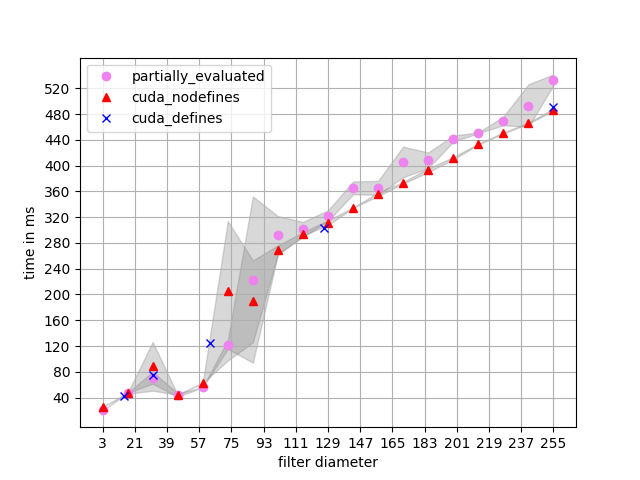

In [16]:
def red(test_list):
    res = [0 for i in range(0,len(test_list[0]))];#12
    for i in test_list: #for each pair
        for j in range(0,len(res)):#7
            res[j]+=(i[j])
    return list(map(lambda x : x / len(test_list) ,res))

def build_set(test_list):
    res = [[] for i in range(0,len(test_list[0][0]))]
    for i in test_list: #for each filter size
        data = red(i) #average for specific run
        for j in range(0,len(test_list[0][0])):
            res[j].append(data[j])
    return res

def deviation(test_list,avg):
    dev = [[0 for i in range(len(test_list[0][0]))] for j in range(len(test_list))] #for each size
    for i in range(len(test_list)): #for each size
        for j in range(len(test_list[i])): #for each clock
            for e in range(len(test_list[i][j])):
                dev[i][e] = dev[i][e] + (((test_list[i][j][e] - avg[e][i])**2) / (len(test_list[i])-1)) #std dev
    res = [[] for i in range(len(avg))]
    for i in range(len(avg)): #for each algorithm
        for e in dev: #for each size
             res[i].append(math.sqrt(e[i]))
    return res

# print(build_set(spec_vs_ha))
# print(deviation(spec_vs_handtuned,build_set(spec_vs_handtuned)))

yticks = [i for i in range(40,541,40)]
plt.yticks(yticks)
plt.xticks(filters2[::9])
plt.grid()

spec_vs_default_final = []
spec_vs_tuned_final = []

with open("filter_hand",'rb') as dump:
    source = dump.read()
    spec_vs_tuned_final = json.loads(source)

with open("filter_default",'rb') as dump:
    source = dump.read()
    spec_vs_default_final = json.loads(source)

# average time for spec and default implementations    
avg_spec_default = build_set(spec_vs_default_final)
# standard deviation
spec_hand_div = deviation(spec_vs_default_final,avg_spec_default)


mns_devplus = [[avg_spec_default[j][i]+spec_hand_div[j][i] for i in range(len(avg_spec_default[j]))] for j in range(len(avg_spec_hand))]
mns_devminus = [[avg_spec_default[j][i]-spec_hand_div[j][i] for i in range(len(avg_spec_default[j]))] for j in range(len(avg_spec_hand))]


plt.fill_between(filters2[::7],mns_devplus[0][::7],mns_devminus[0][::7],interpolate=False,color='gray', alpha=0.3)
plt.fill_between(filters2[::7],mns_devplus[1][::7],mns_devminus[1][::7],interpolate=False,color='gray', alpha=0.3)

plt.plot(filters2[::7],avg_spec_hand[0][::7],'o',label='partially_evaluated',color='violet',markersize=6)
plt.plot(filters2[::7],avg_spec_hand[1][::7],'^',label='cuda_nodefines',color='red',markersize=6)
# plot hand tuned cuda version
plt.plot(filters1,build_set(spec_vs_tuned_final)[1],'x',label='cuda_defines',color='blue',markersize=6)

plt.ylabel('time in ms')
plt.xlabel('filter diameter')

plt.legend()
plt.show()
# plt.savefig('separable_convolution_spec_vs_all_poster_final.pdf')